In [1]:
import math

import pandas as pd
import const
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scipy.stats as stats
from collection.extension.util.general_util import str_to_date, get_max_severity
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
fixes_records = pd.read_csv(
    const.DIR_EXTENSION + '/data/manual_fixes_inspired.csv',
    dtype={'dep_file_fix': bool, 'lockfile_fix': bool, 'dep_file_inspired': bool, 'lockfile_inspired': bool, 'inspired': bool}
)

In [3]:
print('All fixes done by human: %d' % (len(fixes_records),))

All fixes done by human: 1507


In [4]:
dep_or_lock_fixes = fixes_records[
    (fixes_records['dep_file_fix'] == True) | fixes_records['lockfile_fix'] == True
]

print('All records with a fix version in the dep and/or lock file: %d' % (len(dep_or_lock_fixes)))

All records with a fix version in the dep and/or lock file: 983


In [5]:
dep_file_fixes = fixes_records[fixes_records['dep_file_fix'] == True]

print('Number of fixes done through dependency file: %d' % (len(dep_file_fixes)))

lockfile_fixes = fixes_records[fixes_records['lockfile_fix'] == True]

print('Number of fixes done through lockfile: %d' % (len(lockfile_fixes)))

Number of fixes done through dependency file: 266
Number of fixes done through lockfile: 931


In [6]:
fixes_records.groupby(['inspired'])['inspired'].count().to_frame().rename(columns={'inspired':'count'})

,count
inspired,
False,1287
True,220


In [7]:
inspired_fixes = fixes_records[fixes_records['inspired'] == 1]

print('Inspired %d out of %d -> %.2f%%' % (len(inspired_fixes), len(fixes_records), len(inspired_fixes) * 100 / len(fixes_records),))

Inspired 220 out of 1507 -> 14.60%


In [8]:
print('Dependency file inspired: %d out of %d -> %.2f%%' % (
    sum(dep_file_fixes['dep_file_inspired'] == 1),
    len(fixes_records),
    sum(dep_file_fixes['dep_file_inspired'] == 1) * 100 / len(fixes_records),
))

Dependency file inspired: 45 out of 1507 -> 2.99%


In [9]:
print('Lockfile inspired: %d out of %d -> %.2f%%' % (
    sum(lockfile_fixes['lockfile_inspired'] == 1),
    len(fixes_records),
    sum(lockfile_fixes['lockfile_inspired'] == 1) * 100 / len(fixes_records),
))

Lockfile inspired: 203 out of 1507 -> 13.47%


In [10]:
inspired_fix_time = inspired_fixes['fix_time'].apply(lambda x: int(x.split(',')[0]))
len(inspired_fix_time)
print('Median: %.2f / Mean: %.2f' % (inspired_fix_time.median(), inspired_fix_time.mean()))
print('75% quantile:', inspired_fix_time.quantile(0.75))

Median: 68.50 / Mean: 108.38
75% quantile: 136.0


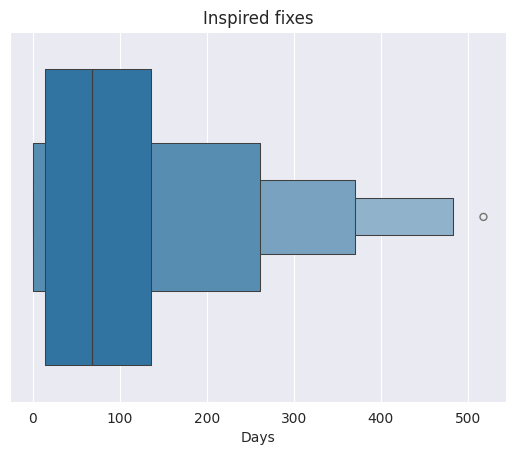

In [11]:
boxen = sns.boxenplot(x=inspired_fix_time)
boxen.set(xlabel='Days', ylabel='')
plt.title('Inspired fixes')
plt.show()

In [12]:
non_inspired_fixes = fixes_records[fixes_records['inspired'] == 0] 
print(len(non_inspired_fixes))

non_inspired_fixes = non_inspired_fixes[
    ~non_inspired_fixes['fix_time'].isnull()
]
print(len(non_inspired_fixes))

non_inspired_time = non_inspired_fixes['fix_time'].apply(lambda x: int(x.split(',')[0]))
print('Median: %.2f / Mean: %.2f' % (non_inspired_time.median(), non_inspired_time.mean()))

print('75% quantile:', non_inspired_time.quantile(0.75))

1287
763
Median: 44.00 / Mean: 97.29
75% quantile: 145.0


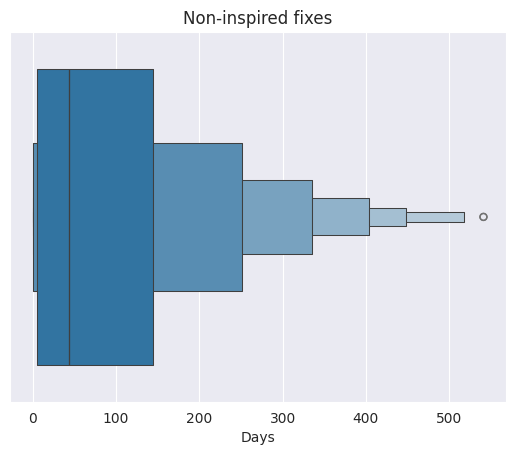

In [13]:
boxen = sns.boxenplot(x=non_inspired_time)
boxen.set(xlabel='Days', ylabel='')
plt.title('Non-inspired fixes')
plt.show()

In [14]:
pd.options.mode.chained_assignment = None 

fix_time_df = fixes_records[~fixes_records['fix_time'].isnull()]
fix_time_df['fix_time_day'] = fix_time_df.apply(lambda r: int(r['fix_time'].split(',')[0]), axis=1)
fix_time_df['inspired'] = fix_time_df['inspired'].astype(str)
# fix_time_df = fix_time_df[fix_time_df['fix_time_day'] < 14]

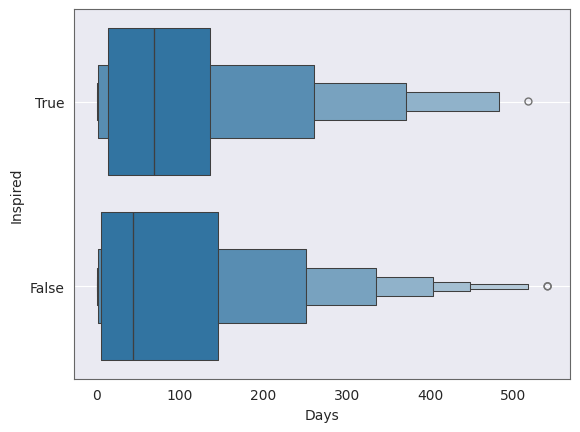

<Figure size 640x480 with 0 Axes>

In [15]:
fig, ax = plt.subplots()

ax = sns.boxenplot(data=fix_time_df, x='fix_time_day', y='inspired', ax=ax)
ax.set(xlabel='Days', ylabel='Inspired')

ax.grid(None)
ax.spines['bottom'].set_color('0.4')
ax.spines['top'].set_color('0.4')
ax.spines['right'].set_color('0.4')
ax.spines['left'].set_color('0.4')

plt.title('')
plt.show()

plt.subplots_adjust(bottom=0.2)


ax.get_figure().savefig('RQ5-fixing-time.png', dpi=800, transparent=True)

In [16]:
# # calculate fix_time for all non-inspired cases, not the ones that we could find a fixing version in their lock/dep file
# security_updates = pd.read_csv(const.CSV_DATA['pr_vulnerabilities'])
# fix_time_df = fixes_records.copy(deep=True)
# 
# fix_time_column = []
# for i, row in fix_time_df.iterrows():
#     if row['inspired'] == 1:
#         fix_time_column.append(row['fix_time'])
#         continue
#     
#     prs = security_updates[
#         (security_updates['repository'] == row['repository']) &
#         (security_updates['package'] == row['package']) &
#         (security_updates['state'] != 'MERGED')
#     ]
# 
#     mft = None
#     for j, pr in prs.iterrows():
#         d = str_to_date(pr['date'], '%Y-%m-%dT%H:%M:%S%z')
#         if mft is None:
#             mft = d
#         elif d > mft:
#             mft = d
#     
#     if mft is None:
#         fix_time_column.append(None)
#         continue
#     
#     # G 2020-01-22 15:51:10-03:00 -> %Y-%m-%d %H:%M:%S%z
# # SE 2019-09-12T17:16:59+05:00 -> %Y-%m-%dT%H:%M:%S%z
#     try:
#         fix_date = str_to_date(row['date'], '%Y-%m-%dT%H:%M:%S%z')
#     except:
#         fix_date = str_to_date(row['date'], '%Y-%m-%d %H:%M:%S%z')
#     delta = fix_date - mft
#     if delta.days < 0:
#         fix_time_column.append(None)
#         continue
# 
#     fix_time_column.append(str(delta.days) + "," + str(delta.seconds // 3600)) 
#     
# fix_time_df['fix_time'] = fix_time_column
# 
# fix_time_df = fix_time_df[~fix_time_df['fix_time'].isnull()]
# 
# fix_time_df['fix_time_day'] = fix_time_df.apply(lambda r: int(r['fix_time'].split(',')[0]), axis=1)
# fix_time_df['inspired'] = fix_time_df['inspired'].astype(str)
# 
# fig, ax = plt.subplots()
# 
# boxen = sns.boxenplot(data=fix_time_df, x='fix_time_day', y='inspired', ax=ax)
# boxen.set(xlabel='Days', ylabel='Inspired')
# plt.title('Fixing time')
# plt.show()

In [17]:
g1 = (fix_time_df[fix_time_df['inspired'] == 'True'])['fix_time_day'].values.tolist()
g2 = (fix_time_df[fix_time_df['inspired'] == 'False'])['fix_time_day'].values.tolist()

print(len(g1))
print(len(g2))

220
763


In [18]:
# check to see if data is normally distributed
w, p_value = stats.shapiro(g1)
print('w: %f, p-value: %.40f, %s normally distributed' % (w, p_value, 'not' if p_value < 0.05 else ''))

w, p_value = stats.shapiro(g2)
print('w: %f, p-value: %.40f, %s normally distributed' % (w, p_value, 'not' if p_value < 0.05 else ''))

w: 0.786096, p-value: 0.0000000000000001218896081704775512894359, not normally distributed
w: 0.787949, p-value: 0.0000000000000000000000000000024566694442, not normally distributed


In [19]:
# check if inspired/non-inspired are statistically different
# hypothesis: if the two groups come from same population

U1, p = mannwhitneyu(x=g1, y=g2)
print(U1, p)
print('Hypothesis %s' % ('rejected' if p < 0.05 else 'verified'))

n1 = len(g1)
n2 = len(g2)

z = (U1 - (n1 * n2 / 2)) / math.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)
print('Z-score:', z)
r = z / math.sqrt(n1 + n2)
print('r (effect size):', r)

90397.5 0.08102405870060532
Hypothesis verified
Z-score: 1.7432348590516058
r (effect size): 0.05560055707373933


In [20]:
g1 = (fix_time_df[(fix_time_df['inspired'] == 'True') & (fix_time_df['fix_time_day'] <= 365)])['fix_time_day'].values.tolist()
g2 = (fix_time_df[(fix_time_df['inspired'] == 'False') & (fix_time_df['fix_time_day'] <= 365)])['fix_time_day'].values.tolist()

U1, p = mannwhitneyu(x=g1, y=g2)
print(U1, p)
print('Hypothesis %s' % ('rejected' if p < 0.05 else 'verified'))

77749.5 0.21710147314409423
Hypothesis verified


In [21]:
hypothesis = []
for i, row in fixes_records.iterrows():
    records = fixes_records[fixes_records['repository'] == row['repository']]
    if len(records) < 4: # minimum sample size
        continue
    
    inspired = records[records['inspired'] == 1]
    non_inspired = records[records['inspired'] == 0]
    
    if len(inspired) == 0 or len(non_inspired) == 0:
        continue
    
    #print('All %d / Inspired %d / Non-inspired %d' % (len(records), len(inspired), len(non_inspired)))
    
    time_df = records[~records['fix_time'].isnull()]
    time_df['fix_time_day'] = fix_time_df.apply(lambda r: int(r['fix_time'].split(',')[0]), axis=1)
    
    if len(time_df) < 4:
        continue
    
    g1 = (time_df[time_df['inspired'] == True])['fix_time_day'].values.tolist()
    g2 = (time_df[time_df['inspired'] == False])['fix_time_day'].values.tolist()
    
    U1, p = mannwhitneyu(x=g1, y=g2)
    #print(U1, p)
    #print('Hypothesis %s' % ('rejected' if p < 0.05 else 'verified'))
    
    hypothesis.append(0 if p < 0.05 else 1)
    

verified = 0
for h in hypothesis:
    if h == 1:
        verified += 1

print('Hypothesis %d, Verified: %d -> %.2f%%' % (len(hypothesis), verified, 100 * verified / len(hypothesis)))


Hypothesis 457, Verified: 430 -> 94.09%


In [22]:
security_updates = pd.read_csv(const.CSV_DATA['pr_vulnerabilities'])

severities = []

for idx, row in inspired_fixes.iterrows():
    records = security_updates[
        (security_updates['repository'] == row['repository']) & 
        (security_updates['package'] == row['package']) &
        (security_updates['maximal_severity'].notnull())
    ]

    sev = None
    if len(records) == 1:
        sev = records.iloc[0]['maximal_severity']
    else:
        sev_set = set(records['maximal_severity'].tolist())
        if len(sev_set) == 1:
            sev = sev_set.pop()
        else:
            sev = get_max_severity(sev_set)

    severities.append(sev)

inspired_fixes['severity'] = severities

In [23]:
critical_df = inspired_fixes[inspired_fixes['severity'] == 'CRITICAL']
high_df = inspired_fixes[inspired_fixes['severity'] == 'HIGH']
moderate_df = inspired_fixes[inspired_fixes['severity'] == 'MODERATE']
low_df = inspired_fixes[inspired_fixes['severity'] == 'LOW']

print('critical -- %.2f%% (%d)' % (100 * len(critical_df) / len(inspired_fixes), len(critical_df)))
print('high -- %.2f%% (%d)' % (100 * len(high_df) / len(inspired_fixes), len(high_df)))
print('moderate -- %.2f%% (%d)' % (100 * len(moderate_df) / len(inspired_fixes), len(moderate_df)))
print('low -- %.2f%% (%d)' % (100 * len(low_df) / len(inspired_fixes), len(low_df)))


critical -- 6.82% (15)
high -- 45.00% (99)
moderate -- 43.18% (95)
low -- 5.00% (11)


In [24]:
severities = []

for idx, row in non_inspired_fixes.iterrows():
    records = security_updates[
        (security_updates['repository'] == row['repository']) & 
        (security_updates['package'] == row['package']) &
        (security_updates['maximal_severity'].notnull())
    ]

    sev = None
    if len(records) == 1:
        sev = records.iloc[0]['maximal_severity']
    else:
        sev_set = set(records['maximal_severity'].tolist())
        if len(sev_set) == 1:
            sev = sev_set.pop()
        else:
            sev = get_max_severity(sev_set)

    severities.append(sev)

non_inspired_fixes['severity'] = severities

In [25]:
critical_df = non_inspired_fixes[non_inspired_fixes['severity'] == 'CRITICAL']
high_df = non_inspired_fixes[non_inspired_fixes['severity'] == 'HIGH']
moderate_df = non_inspired_fixes[non_inspired_fixes['severity'] == 'MODERATE']
low_df = non_inspired_fixes[non_inspired_fixes['severity'] == 'LOW']

print('* non-inspired:')
print('critical -- %.2f%% (%d)' % (100 * len(critical_df) / len(non_inspired_fixes), len(critical_df)))
print('high -- %.2f%% (%d)' % (100 * len(high_df) / len(non_inspired_fixes), len(high_df)))
print('moderate -- %.2f%% (%d)' % (100 * len(moderate_df) / len(non_inspired_fixes), len(moderate_df)))
print('low -- %.2f%% (%d)' % (100 * len(low_df) / len(non_inspired_fixes), len(low_df)))


* non-inspired:
critical -- 10.88% (83)
high -- 50.07% (382)
moderate -- 28.83% (220)
low -- 10.22% (78)


In [26]:
sev_count1 = non_inspired_fixes.groupby('severity', as_index=False).count()['repository'].tolist()
sev_count2 = inspired_fixes.groupby('severity', as_index=False).count()['repository'].tolist()

print(sev_count1, sev_count2)

table = np.array([sev_count1, sev_count2])
res = chi2_contingency(table)

print(res)

[83, 382, 78, 220] [15, 99, 11, 95]
Chi2ContingencyResult(statistic=19.834267306868746, pvalue=0.0001837090940563091, dof=3, expected_freq=array([[ 76.0671414 , 373.34994914,  69.08138352, 244.50152594],
       [ 21.9328586 , 107.65005086,  19.91861648,  70.49847406]]))


In [27]:
def severity_to_int(sev_str):
    if sev_str == 'CRITICAL':
        return 4
    elif sev_str == 'HIGH':
        return 3
    elif sev_str == 'MODERATE':
        return 2
    elif sev_str == 'LOW':
        return 1
    raise Exception('Invalid severity')

inspired_fixes['severity_int'] = inspired_fixes['severity'].apply(severity_to_int)
non_inspired_fixes['severity_int'] = non_inspired_fixes['severity'].apply(severity_to_int)

stat, p = mannwhitneyu(inspired_fixes['severity_int'].tolist(), non_inspired_fixes['severity_int'].tolist())

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-Value: {p}")

Mann-Whitney U Statistic: 77522.5
P-Value: 0.06077911470158867
